<a name=Indice></a>
# Índice
1. [Análisis de datos](#Análisisdedatos)
 1. [Análisis de la variable dependiente](#Análisisdelavariabledependiente)
 2. [Análisis de las variables explicativas](#Análisisdelasvariablesexplicativas)
2. [Entrenamiento de modelos](#Entrenamientodemodelos)
    1. [Preparación de datos](#Preparacióndedatos)
    2. [Experimentos](#Experimentos)
    3. [Comparación de modelos](#Comparacióndemodelos)
    4. [Optimización y combinación de modelos](#Optimizacion)
3. [Predicción](#Predicción)
4. [Anexo 1: Otros modelos considerados](#Anexo1)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import xgboost as xgb
from bayes_opt import BayesianOptimization
from tpot import TPOTRegressor
from mlens.ensemble import SuperLearner,BlendEnsemble
from sklearn.metrics import make_scorer,precision_score,accuracy_score,recall_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,HuberRegressor,SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.model_selection import KFold,cross_val_score
from sklearn.tree import DecisionTreeRegressor

[MLENS] backend: threading


In [2]:
#Cargamos los datos de entrenamiento
train_df = pd.read_csv("data/original/Dataset_Salesforce_Predictive_Modelling_TRAIN.txt")

/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


El objetivo de este reto es es desarollo de un modelo capaz de predecir el poder adquisitivo de un cliente a partir de una serie de variables disponibles para la entidad financiera. Contar con un modelo preciso que pueda llevar a cabo estars predicciones sin duda conllevaría muchas ventajas a la hora de recomendar productos al cliente que se adecuen a sus necesidades y capacidades.

<a name=Análisisdedatos></a>
# Análisis de datos
[Volver al Indice](#Indice)

 Veamos un ejemplo de los datos con los que contamos.

In [ ]:
train_df.head()

In [ ]:
train_df.columns

In [ ]:
train_df.dtypes

In [ ]:
len(train_df)

Tal y como se explica en el enunciado, contamos con 88 variables que usar para predecir el poder adquisitivo y la información de cerca de 363.000 clientes con los que entrenar nuestro modelo. Esto hace que contemos con un número importante de datos que nos puede ayudar a desarrollar un modelo que tenga un rendimiento adecuado.

<a name=Análisisdelavariabledependiente> </a>
## Análisis de la variable dependiente 
Miremos con más detenimiento la variable a predecir.


In [ ]:
train_df["Poder_Adquisitivo"].describe()

In [ ]:
sns.distplot(train_df["Poder_Adquisitivo"])

In [ ]:
print("Skewness: %f" % train_df["Poder_Adquisitivo"].skew())
print("Kurtosis: %f" % train_df["Poder_Adquisitivo"].kurt())

In [ ]:
q1 = train_df["Poder_Adquisitivo"].quantile(0.25)
q3 = train_df["Poder_Adquisitivo"].quantile(0.75)
iqr = q3 - q1
fence_low  = q1 - 1.5 * iqr
fence_high = q3 + 1.5 * iqr

train_df_no_outliers = train_df.loc[(train_df["Poder_Adquisitivo"] > fence_low) & (train_df["Poder_Adquisitivo"] < fence_high)]
sns.distplot(train_df_no_outliers["Poder_Adquisitivo"])

In [ ]:
print("Skewness: %f" % train_df_no_outliers["Poder_Adquisitivo"].skew())
print("Kurtosis: %f" % train_df_no_outliers["Poder_Adquisitivo"].kurt())

In [ ]:
print("Porcentaje de datos eliminados:")
print((len(train_df.index)-len(train_df_no_outliers.index))/len(train_df.index))

Eliminando de esta manera los valores extremos, que representan alrededor del 5% de los datos totales, la distribución ahora presenta unos valores de skewness y kurtosis mucho más aceptables que permitan el entrenamiento de un modelo.

Evidentemente esta eliminación se va a realizar únicamente a la hora de entrenar, nunca a la hora de evaluar

<a name=Análisisdelasvariablesexplicativas></a>
## Análisis de las variables explicativas

De las variables explicativas, sabemos que contamos con algunas que son de tipo categórico en vez de númerico. Empezemos explorando estas variables.

In [ ]:
train_df_no_outliers["Socio_Demo_01"].value_counts()

Podemos observar como Socio_Demo_01 que cuenta que muchos valores que solo aparecen un número muy bajo de veces. A la hora de transformar para su uso, es probable que la inclusión de los 921 valores posibles no aporte información discriminativa y solo sirva para aumentar el número de dimensiones. Una primera aproximación que mantenga un equilibrio entre complejidad y utilidad puede ser usar solo un número de estos valores, aquellos que aparezcan un mayor número de veces, y condensar el resto en una categoría "Other".

In [ ]:
topk_socio_01 = train_df_no_outliers["Socio_Demo_01"].value_counts()[:10]
topk_socio_01

In [ ]:
socio_01_keys = list(topk_socio_01.keys())
condition_array = [False] * len(train_df_no_outliers["Socio_Demo_01"])
for i in range(len(condition_array)):
    condition_array[i] = str(train_df_no_outliers["Socio_Demo_01"].iloc[i]) in socio_01_keys

sns.violinplot(x=train_df_no_outliers["Socio_Demo_01"].loc[condition_array],y=train_df_no_outliers["Poder_Adquisitivo"].loc[condition_array])

Es interesante ver como algunos valores como 09992 parecen concentrar la mayor parte de clientes en valores diferentes del resto, lo cual puede aportar información importante.

In [ ]:
train_df_no_outliers["Socio_Demo_02"].value_counts()

In [ ]:
sns.violinplot(x=train_df_no_outliers["Socio_Demo_02"],y=train_df_no_outliers["Poder_Adquisitivo"])

Veamos el resto de variables socio demográficas.

In [ ]:
sns.distplot(train_df_no_outliers["Socio_Demo_03"])

In [ ]:
sns.jointplot(x=train_df_no_outliers["Socio_Demo_03"], y=train_df_no_outliers["Poder_Adquisitivo"],kind='kde')

In [ ]:
sns.distplot(train_df_no_outliers["Socio_Demo_04"])

In [ ]:
sns.jointplot(x=train_df_no_outliers["Socio_Demo_04"], y=train_df_no_outliers["Poder_Adquisitivo"],kind='kde')

In [ ]:
train_df_no_outliers["Socio_Demo_04"].value_counts()

De nuevo, observamos que una serie pequeña de valores concentra la gran mayoría de ocurrencias. Veamos si existe una relación aparente entre cada valor de esta variable y el poder adquisitivo.

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
sns.boxplot(x=train_df_no_outliers["Socio_Demo_04"], y=train_df_no_outliers["Poder_Adquisitivo"],ax=ax)

Algunos valores muestran distribuciones que son diferentes a las demás, pero aparecen un número casi insignificante de veces respecto a la totalidad de los datos, por lo que no consideremos que sea necesario complicar el modelo con esos casos.

In [ ]:
sns.distplot(train_df_no_outliers["Socio_Demo_05"])

In [ ]:
sns.jointplot(x=train_df_no_outliers["Socio_Demo_05"], y=train_df_no_outliers["Poder_Adquisitivo"],kind='kde')

Veamos ahora la correlación de las variables explicativas con el poder adquisitivo, medida mediante el coeficiente de Pearson.

In [ ]:
train_df_no_outliers.corr(method='pearson').iloc[-1].sort_values(ascending=False,axis=0)[1:]

Vemos como algunas variables presentan coeficientes de correlación medios, lo que indica que serán útiles para los modelos.

<a name=Entrenamientodemodelos></a>
# Entrenamiento de modelos
[Volver al Indice](#Indice)

<a name=Preparacióndedatos></a>
## Preparación de datos
Con todo lo visto anteriormente estamos listos para preparar los datos para la experimentación. Vamos a definir una función que realize este pre-procesado de los datos. 

La transformación básica consiste en convertir las variables categóricas a valores one-hot, y eliminar la columna ID_Customer que no es más que un identificador del cliente.


Con processing_type = 1 se puede indicar además que queremos filtrar los outliers (pero únicamente en tiempo de entrenamiento)



In [3]:
def process_df(df,processing_type,train = True):
    if processing_type == 1:
        return process_df_1(df,train)
    else:
        return process_df_1(df,False)
    
def process_df_1(df,train = True):
    df = df.drop(labels=["ID_Customer"],axis=1)
    
    if train:
        # Eliminamos los outliers solo en el caso de que estemos entrenando
        q1 = df["Poder_Adquisitivo"].quantile(0.25)
        q3 = df["Poder_Adquisitivo"].quantile(0.75)
        iqr = q3 - q1
        fence_low  = q1 - 1.5 * iqr
        fence_high = q3 + 1.5 * iqr

        df = df.loc[(df["Poder_Adquisitivo"] > fence_low) & (df["Poder_Adquisitivo"] < fence_high)]
    
        
    
    # Convertimos las variables a one-hot

    # Socio_Demo_01
    
    topk_socio_01 = df["Socio_Demo_01"].value_counts()[:10]
    socio_01_keys = list(topk_socio_01.keys())
    
    for key in socio_01_keys:
        on = df["Socio_Demo_01"] == key
        df.insert(loc=len(df.columns), column="Socio_Demo_01_"+str(key), value=on.astype(int))
    
    # El resto lso agrupamos en 'Other'
    condition_array = [False] * len(df["Socio_Demo_01"])
    for i in range(len(condition_array)):
        condition_array[i] = str(df["Socio_Demo_01"].iloc[i]) not in socio_01_keys
    df.insert(loc=len(df.columns), column="Socio_Demo_01_Other", value=condition_array)
    df["Socio_Demo_01_Other"] = df["Socio_Demo_01_Other"].astype(int)
    
    df = df.drop(axis=1, columns=["Socio_Demo_01"])
    
    # Socio_Demo_02
    c1=df["Socio_Demo_02"] == 1
    c2=df["Socio_Demo_02"] == 2
    df.insert(loc=len(df.columns), column="Socio_Demo_02_01", value=c1.astype(int))
    df.insert(loc=len(df.columns), column="Socio_Demo_02_02", value=c2.astype(int))
    
    df = df.drop(axis=1, columns=["Socio_Demo_02"])

    
    # Convertimos todas las columnas Ind_prod a one-hot
    
    for i in range(1,25):
        column_name = "Ind_Prod_" + str(i).zfill(2)
        c0=df[column_name] == 0
        c1=df[column_name] == 1
        c2=df[column_name] == 2
        
        df.insert(loc=len(df.columns), column=column_name + "_00", value=c0.astype(int))
        df.insert(loc=len(df.columns), column=column_name + "_01", value=c1.astype(int))
        df.insert(loc=len(df.columns), column=column_name + "_02", value=c2.astype(int))
    
        df = df.drop(axis=1, columns=[column_name])
    
    
    
    return df

En primer lugar vamos a barjar los datos, y a continuación vamos a realizar una partición de los datos para realizar **validación cruzada** en 5 bloques, con el objetivo de realizar un análisis de resultados de los diferentes modelos de manera correcta y fiable.

Este método divide los datos en los conjustos de entrenamiento y test para cada partición, y los almacena en la variable splits.

In [4]:
SEED = 4
K = 5

shuffled_data = train_df.sample(frac=1,replace=False,random_state=SEED)

kf = KFold(n_splits=K)
kf.get_n_splits(shuffled_data)

def get_splits(kf,processing_type):
    splits=[]
    for train_index, test_index in kf.split(shuffled_data):
        train_data = shuffled_data.loc[train_index]
        test_data = shuffled_data.loc[test_index]

        train_data_proc = process_df(train_data,processing_type,train=True)
        test_data_proc = process_df(test_data,processing_type,train=False)


        splits.append((train_data_proc,test_data_proc))
    return splits


Dado un modelo y los splits que hemos realizado a los datos, a continuación definimos una función que, para cada partición de entrenamiento y test, entrene un modelo con los datos de entrenamiento correspondiente y calcule métricas sobre el conjunto de validación.

En lo que se refiere a métricas, en primer lugar hemos escogido la **ráiz del error cuadrático medio (RMSE)**, una de las métricas más comunes para evaluar modelos de regresión. El problema que tiene esta métrica es que penaliza de manera desmedida fallos grandes. Resulta mucho más interesante medir el funcionamiento del algoritmo con una métrica que refleje mejor su funcionamiento con la mayoría de clientes, cosa que consideramos más útil a la hora de decidirnos por un modelo u otro. Por eso medimos los resultados con respecto a la **media del error absoluto (MAE)** y a la **mediana del error (MAD).** Esta última métrica no es susceptible a outliers y nos permite conocer mejor cual es el comportamiento "medio" de cada modelo.

In [5]:
def train_and_evaluate(model,splits,skcompat=False,scaler=None):
    rmse = []
    mae = []
    mad = []
    # Para cada iteración de validación cruzada
    for s in range(len(splits)):
        train_data_proc,test_data_proc = splits[s]
        
        # Obtenemos los datos de entrenamiento
        x_train = train_data_proc.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
        y_train = train_data_proc["Poder_Adquisitivo"].as_matrix()

        # Obtenemos los datos de test
        x_test = test_data_proc.drop(labels=["Poder_Adquisitivo"], axis=1).as_matrix()
        y_test = test_data_proc["Poder_Adquisitivo"].as_matrix()
        
        # Damos la posiblidad de usar un scaler
        if scaler is not None:
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
           
        # Caso base, entrenamos un modelo y obtenemos las predicciones
        if not skcompat:
            model.fit(X=x_train,y=y_train)
            
            # For compatibility with XGBoost
            # yhat = model.predict(X=x_test)
            yhat = model.predict(x_test)
        
        # En el caso de que sea un objeto skcompat, las llamadas a los métodos son ligeramente diferentes.
        else:
            model.fit(x=x_train,y=y_train,steps=STEPS)
            yhat = model.predict(x=x_test)['scores']
        
        # Calculamos métricas 
        rmse.append(math.sqrt(mean_squared_error(y_true=y_test, y_pred=yhat)))
        mae.append(mean_absolute_error(y_true=y_test,y_pred=yhat))
        mad.append(median_absolute_error(y_true=y_test,y_pred=yhat))
        
    return (rmse,mae,mad)

Por último, nos definimos un método para guardar los resultados para su posterior visualización.

In [6]:
scores = {'modelo':[], 'rmse':[],'mae':[],'mad':[]}

def record_scores(name,rmse,mae,mad):
    scores['modelo'].append(name)
    scores['rmse'].append(rmse)
    scores['mae'].append(mae)
    scores['mad'].append(mad)

<a name=Experimentos></a>
## Experimentos

A continuación vamos a exponer una serie de resultados que hemos obtenido evaluando diferentes modelos. Cabe destacar que la cantidad de experimentos realizada es mucho mayor de la mostrada aquí, pero se ha llevado a cabo una selección de aquellos que, a nuestro juicio, son más interesantes. En caso contrario este documento hubiera sido todavía más largo de lo que ya es.

En primer lugar probaremos diferentes modelos tras aplicar el preproceso en el que eliminamos **outliers.**

In [ ]:
splits = []
splits = get_splits(kf,1)

Inicialmente probamos diferentes modelos de regresión lineal.

In [ ]:
model = LinearRegression()
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('Linear Regresion',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(50,50,50,50),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('ANN50*4',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

Probamos ahora diferentes modelos basados en árboles.

In [ ]:
model = DecisionTreeRegressor(min_samples_split=200, min_samples_leaf=50, random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('RegressionTree',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=23, max_features='log2',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('RF_d23',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=23, max_features='auto',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('RF_d23_FULL',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

El permitir que se hagan splits sobre todas las features incrementa sustancialmente el tiempo de entrenamiento, pero hace que este modelo supere al rest.

Probamos ahora con la técnica de Gradient Boosting.

In [ ]:
model = GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5,max_depth=5)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('Gradient Boost_d5',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
model = GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5,max_depth=7)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('Gradient Boost_d7',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

De nuevo, llegados a este punto los modelos empiezan a requerar un tiempo de entrenamiento elevado a medida que se aumenta la profundidad máxima.

Una comparación importante a realizar es comprobar si nuestra idea inicial de eliminar outliers ha dado sus frutos. Probamos ahora a entrenar una serie de modelos ***sin eliminar outliers***.

In [ ]:
splits = []
splits = get_splits(kf,0)

In [ ]:
model = LinearRegression()
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('raw Linear Regression',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(50,50,50,50),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('raw ANN50*4',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
model = GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5,max_depth=5)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('raw Gradient Boost_d5',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
model = GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5,max_depth=7)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('raw Gradient Boost_d7',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

"""
RMSE: 19659.521910
MAE: 4686.435566
MAD: 2390.403421
"""
""" Y un  montón de tiempo"""

In [ ]:
%%time
params =  {'max_depth': 13, 'eta': 0.1, 'silent': 1, 'objective': 'reg:linear', 'subsample':0.8,'eval_metric':'rmse','nthread':4,'seed':SEED}
model = XGBoostModel(params,100)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw_XGB_d13_eta0.1_n100_sbspl',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:

model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=23, max_features='auto',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw RF_d23_FULL',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
%%time
model = xgb.XGBRegressor(max_depth=13, learning_rate=0.1, alpha=0,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=0.8,colsample_bytree=1.0,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw_XGB_d13_eta0.1_n100_sbspl',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
%%time
model = xgb.XGBRegressor(max_depth=13, learning_rate=0.1, alpha=0,n_estimators=50, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=0.8,colsample_bytree=1.0,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw_XGB_d13_eta0.1_n100_sbspl',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

Sorprendentemente, si bien para el resto de modelos si que apreciamos que el filtrado de outliers supone sustanciales ganancias en términos de MAE y MAD, en el caso del Random Forest la pequeña diferencia en MAD se ve compensado por una reducción muy importante en RMSE y MAE. 

<a name=Comparacióndemodelos></a>
## Comparación de modelos

In [ ]:
scores_df = pd.DataFrame(data=scores)

scores_df = scores_df.set_index('modelo')

display(scores_df)

In [ ]:
scores_df = scores_df.sort_values(by="mad")
scores_df.plot(kind='bar',y='mad',colormap='Blues_r',figsize=(12, 8))

In [ ]:
scores_df = scores_df.sort_values(by="mae")
scores_df.plot(kind='bar',y='mae',colormap='Oranges_r',figsize=(12, 8))

In [ ]:
scores_df = scores_df.sort_values(by="rmse")
scores_df.plot(kind='bar',y='rmse',colormap='Greens_r',figsize=(12, 8))

Teniendo en cuenta todo esto, finalmente nos hemos decidido por el modelo **raw RF_d23_n100_FULL**. Inicialmente, y con la mayoría de modelos, nuestra idea inicial de eliminar outliers había obtenido mejoras muy grandes en MAE y MAD que, a nuestro juicio, compensaban de sobra pequeñas pérdidas en RMSE ya que mejoraban el conjunto de las predicciones. Sin embargo, los modelos de Random Forest profundos han demostrado que son capaces de reducir de enorme manera los grandes errores cometidos en algunos clientes puntuales, a cambio de una pequeña pérdida de MAD. Si bien el rendimiento se reducirá muy ligeramente en general (en realidad se reduce de manera ínfima, si nos fijamos en el MAD, significa que el error mediano empeora sólo en 30€), esto nos va a permitir cometer fallos mucho más pequeños en clientes atípicos, ya que reducimos en más de 4000€ el RMSE, por lo que finalmente hemos optado por este modelo. 

<a name=Optimizacion></a>
## Optimización y combinación de modelos

De todos estos experimentos, se puede observar como los modelos más prometedores son el RandomForest y el GradientBoosting implementado sobre XGBoost. Ahora lo que nos gustaría hacer es encontrar los mejores hiperparámetros para estos problemas. Dado un cierto modelo, se puede entender el proceso de encontrar los **hiperparámetros óptimos** como un proceso de optimización de una **función**, que devuelve las métricas de validación cruzada del modelo, y cuyos **argumentos** son los hiperparámetros del modelo. Esta función es difícil de optimizar ya que:

* Es una función **muy costosa** de evaluar, tenemos que entrenar por completo un modelo cada vez que queramos extraer un punto.
* Tiene un **espacio grande** de posibles parámetros/argumentos.
* **Desconocemos la estructura** de este espacio y las **interacciones entre los diferentes argumentos**.

La **Optimización Bayesiana** nos ofrece una solución a este problema, ya que es una técnica pensada para optimizar funciones de tipo **caja-negra** como la que tenemos entre manos.

In [ ]:
f_train_df = process_df(shuffled_data,0,train = True)

X_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()

xgtrain = xgb.DMatrix(X_train, label=y_train)


def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)


    cv_result = xgb.cv(params, xgtrain, num_boost_round=100, nfold=5,
             seed=random_state,
             callbacks=[xgb.callback.early_stop(5)])

    return -cv_result['test-mae-mean'].values[-1]





random_state = SEED
num_iter = 50
init_points = 25
params = {
    'eta': 0.1,
    'silent': 1,
    'eval_metric': 'mae',
    'verbose_eval': True,
    'seed': random_state
}

xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                            'colsample_bytree': (0.1, 1),
                                            'max_depth': (5, 20),
                                            'subsample': (0.5, 1),
                                            'gamma': (0, 15),
                                            'alpha': (0, 15),
                                            })

xgbBO.maximize(init_points=init_points, n_iter=num_iter)

print(xgbBO.res['max'])

In [ ]:
f_train_df = process_df(shuffled_data,0,train = True)

X_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()

def model_evaluate(n_estimators,
                 max_depth,
                max_features,
                 min_samples_leaf,
                  ):

    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_leaf = int(min_samples_leaf)
    max_features = max(min(max_features, 1), 0.1)

    model = RandomForestRegressor(n_estimators=n_estimators,
                 max_depth=max_depth,
                max_features=max_features,
                 min_samples_leaf=min_samples_leaf,
                                 n_jobs=4,random_state=SEED)

    cv_result = cross_val_score(model,X_train,y_train,cv=kf,scoring="neg_median_absolute_error")

    return np.mean(cv_result)


num_iter = 50
init_points = 10


modelBO_2 = BayesianOptimization(model_evaluate, {'n_estimators': (30, 100),
                                            'max_depth': (17, 27),
                                            'min_samples_leaf': (5, 200),
                                                'max_features' :(0.5,1),
                                            })

modelBO_2.maximize(init_points=init_points, n_iter=num_iter)

print(modelBO_2.res['max'])

Como resultado del proceso de optimización hemos obtenido los siguientes parámetros para los dos modelos:

In [ ]:
%%time
model = xgb.XGBRegressor(max_depth=20, learning_rate=0.1, alpha=0,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=20.0,random_state=SEED )

scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('opt_xgb_Boost',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=23, max_features='auto',min_samples_leaf=50,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('opt_raw RF_d23_FULL',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

A la hora de escoger el mejor modelo, una primera aproximación consiste en escoger el modelo que haya obtenido mejores resultados. Otra opción más avanzada consiste en hacer una **combinación de modelos**. Veamos que sucedería si realizaramos una combinación de modelos utilizando el mismo modelo pero cambiando la semilla aleatoria.

In [7]:
stk_train_df = process_df(shuffled_data.iloc[:int(shuffled_data.shape[0]*0.8)].copy(),0)
stk_test_df = process_df(shuffled_data.iloc[int(shuffled_data.shape[0]*0.8):].copy(),0)


X_train = stk_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = stk_train_df["Poder_Adquisitivo"].as_matrix()

X_test = stk_test_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_test = stk_test_df["Poder_Adquisitivo"].as_matrix()

model_xgb = xgb.XGBRegressor(max_depth=20, learning_rate=0.1, alpha=0,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=20.0,random_state=SEED)

model_rf = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=23,
                                 max_features='auto',min_samples_leaf=50,random_state=SEED)

model_xgb.fit(X_train,y_train)
residuals_xgb = y_test - model_xgb.predict(X_test)

model_rf.fit(X_train,y_train)
residuals_rf = y_test - model_rf.predict(X_test)


model_xgb2 = xgb.XGBRegressor(max_depth=20, learning_rate=0.1, alpha=0,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=20.0,random_state=33)

model_rf2 = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=23,
                                 max_features='auto',min_samples_leaf=50,random_state=33)

model_xgb2.fit(X_train,y_train)
residuals_xgb2 = y_test - model_xgb2.predict(X_test)

model_rf2.fit(X_train,y_train)
residuals_rf2 = y_test - model_rf2.predict(X_test)




Estudiemos la correlación que existe entre los errores que cometen los 4 modelos, 2 Random Forest y dos Gradient Boosts entrenados con XGBoost, entrenados con diferentes semillas, según la p de Pearson:

In [ ]:
df = pd.DataFrame(data={'residuals_rf':residuals_rf,'residuals_xgb':residuals_xgb,'residuals_rf2':residuals_rf2,
                        'residuals_xgb2':residuals_xgb2})
corr = df.corr()
corr

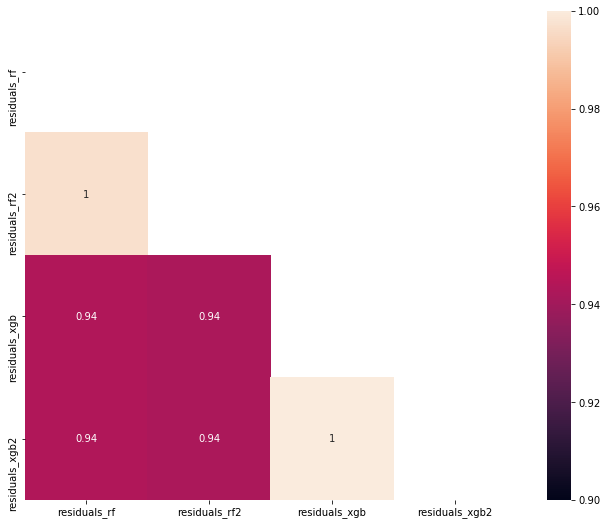

In [28]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,annot=True,vmin=0.9, vmax=1.00)

Podemos ver como los errores que comete un tipo de modelo están completamente correlacionados, independientemente de que se haya variado la semilla aleatoria. Por tanto, esto quiere decir que los modelos **cometen los mismos errores**. Hacer una combinación de modelos entrenados con distinta semilla, por tanto, no parece añadir muchas ventajas.

En cambio, los errores comeditos por los modelos xgb y los Random Forest, si bien están fuertemente correlacionados, no son exactamente iguales. Los diferentes modelos no se equivoca, ni en el mismo sitio, ni de la misma manera. Combinar dos modelos diferentes, por tanto, nos aporta **diversidad**, y puede ayudarnos a mejorar los resultados ya que un modelo puede compensar fallos puntuales del otro para ciertos clientes.

In [22]:
class WeightedEnsemble:
    def __init__(self,models,weights):
        self.models = models
        self.weights = weights
        
    def fit(self,X,y):
        for model in self.models:
            model.fit(X,y)
            
    def predict(self,X):
        y = np.zeros((X.shape[0]))
        for i in range(len(self.models)):
            y += (self.models[i].predict(X) * self.weights[i])
        return y

In [ ]:
%%time
ensemble = WeightedEnsemble([xgb.XGBRegressor(max_depth=15, learning_rate=0.1, alpha=10,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=1.0,random_state=SEED),
                            RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)],
                            [0.5,0.5])

scores_rmse,scores_mae,scores_mad = train_and_evaluate(ensemble,splits)

print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('beta_ensemble',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
%%time
ensemble = WeightedEnsemble([xgb.XGBRegressor(max_depth=20, learning_rate=0.1, alpha=0,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=20.0,random_state=SEED ),
                            RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)],
                            [0.5,0.5])

scores_rmse,scores_mae,scores_mad = train_and_evaluate(ensemble,splits)

print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('beta_ensemble',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

<a name=Predicción></a>
# Predicción
[Volver al Indice](#Indice)

In [ ]:
splits = []

model = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=23, max_features='auto',min_samples_leaf=5,random_state=SEED)

# Entrenamos con todos los datos
f_train_df = process_df(train_df,0,train = True)

x_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()



model.fit(X=x_train,y=y_train)


test_df = pd.read_csv("data/original/Dataset_Salesforce_Predictive_Modelling_TEST.txt")
ids = test_df["ID_Customer"].copy()
test_df =  process_df(test_df,0,train = False)

x_test = test_df.as_matrix()

# Estiamamos el poder adquisitivo
y = model.predict(X=x_test)




Solo nos falta escribir estos resultados en disco.

In [ ]:
out = pd.DataFrame(np.stack((ids, y), axis=1, out=None), columns=['ID_Customer', 'PA_Est']).set_index('ID_Customer')
out.to_csv('Test_Mission.txt')

<a name=Anexo1></a>
# Anexo 1: Otros modelos considerados
[Volver al Indice](#Indice)

In [ ]:
splits 1

In [ ]:
model = Lasso(random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('Lasso',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
model = Ridge(random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('Ridge',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
model = ElasticNet(random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('ElasticNet',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

Todos los modelos lineales parecen obtener resultados comparables. Probamos ahora con redes neuronales.

In [ ]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(25,25,25),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))



In [ ]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(50,50,50),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))


In [ ]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(25,25,25,25),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))


In [ ]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(25,25,25,25,25),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))



In [ ]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=5, max_features='log2',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

In [ ]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=7, max_features='log2',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

Podemos ver como la profundidad máxima afecta de manera importante al rendimiento.

In [ ]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=17, max_features='log2',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('RF_d17',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
model = GradientBoostingRegressor(random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

In [ ]:
model = GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

In [ ]:
splits 0

In [ ]:
model = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=23, max_features='auto',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw RF_d23_n100_FULL',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=24, max_features='auto',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw RF_d24_FULL',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
model = GradientBoostingRegressor(random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('raw Gradient Boost_d3',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

# Experimentos fase 2

In [ ]:
%%time
params =  {'max_depth': 7, 'eta': 0.1, 'silent': 1, 'objective': 'reg:linear', 'eval_metric':'rmse','nthread':3, 'seed':SEED}
model = XGBoostModel(params,100)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw_XGB_d7_eta0.1_n100',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
%%time
params =  {'max_depth': 9, 'eta': 0.1, 'silent': 1, 'objective': 'reg:linear', 'eval_metric':'rmse','nthread':3,'seed':SEED}
model = XGBoostModel(params,100)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw_XGB_d9_eta0.1_n100',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
%%time
params =  {'max_depth': 13, 'eta': 0.1, 'silent': 1, 'objective': 'reg:linear', 'eval_metric':'rmse','nthread':3,'seed':SEED}
model = XGBoostModel(params,100)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw_XGB_d13_eta0.1_n100',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
%%time
params =  {'max_depth': 13, 'eta': 0.1, 'silent': 1, 'objective': 'reg:linear', 'subsample':0.8,'eval_metric':'rmse','nthread':4,'seed':SEED}
model = XGBoostModel(params,100)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw_XGB_d13_eta0.1_n100_sbspl',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

# Bayesian optimization

In [ ]:
f_train_df = process_df(shuffled_data,0,train = True)

X_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()

xgtrain = xgb.DMatrix(X_train, label=y_train)


def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)


    cv_result = xgb.cv(params, xgtrain, num_boost_round=100, nfold=5,
             seed=random_state,
             callbacks=[xgb.callback.early_stop(5)])

    return -cv_result['test-mae-mean'].values[-1]





random_state = SEED
num_iter = 50
init_points = 25
params = {
    'eta': 0.1,
    'silent': 1,
    'eval_metric': 'mae',
    'verbose_eval': True,
    'seed': random_state
}

xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                            'colsample_bytree': (0.1, 1),
                                            'max_depth': (5, 20),
                                            'subsample': (0.5, 1),
                                            'gamma': (0, 15),
                                            'alpha': (0, 15),
                                            })

xgbBO.maximize(init_points=init_points, n_iter=num_iter)

print(xgbBO.res['max'])

In [ ]:
f_train_df = process_df(shuffled_data,1,train = True)

X_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()

xgtrain = xgb.DMatrix(X_train, label=y_train)


def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)


    cv_result = xgb.cv(params, xgtrain, num_boost_round=100, nfold=5,
             seed=random_state,
             callbacks=[xgb.callback.early_stop(5)])

    return -cv_result['test-mae-mean'].values[-1]





random_state = SEED
num_iter = 50
init_points = 25
params = {
    'eta': 0.1,
    'silent': 1,
    'eval_metric': 'mae',
    'verbose_eval': True,
    'seed': random_state
}

xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                            'colsample_bytree': (0.1, 1),
                                            'max_depth': (5, 20),
                                            'subsample': (0.5, 1),
                                            'gamma': (0, 15),
                                            'alpha': (0, 15),
                                            })

xgbBO.maximize(init_points=init_points, n_iter=num_iter)

print(xgbBO.res['max'])

In [ ]:
f_train_df = process_df(shuffled_data,0,train = True)

X_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()

def model_evaluate(n_estimators,
                 max_depth,
                max_features,
                 min_samples_leaf,
                  ):

    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_leaf = int(min_samples_leaf)
    max_features = max(min(max_features, 1), 0.1)

    model = RandomForestRegressor(n_estimators=n_estimators,
                 max_depth=max_depth,
                max_features=max_features,
                 min_samples_leaf=min_samples_leaf,
                                 n_jobs=4,random_state=SEED)

    cv_result = cross_val_score(model,X_train,y_train,cv=kf,scoring="neg_mean_absolute_error")

    return np.mean(cv_result)


num_iter = 50
init_points = 15


modelBO = BayesianOptimization(model_evaluate, {'n_estimators': (30, 100),
                                            'max_depth': (15, 25),
                                            'min_samples_leaf': (1, 200),
                                                'max_features' :(0.1,1),
                                            })

modelBO.maximize(init_points=init_points, n_iter=num_iter)

print(modelBO.res['max'])

In [ ]:
%%time 
model = RandomForestRegressor(n_estimators=100,
                 max_depth=25,
                max_features=1.0,
                 min_samples_leaf=31,
                                 n_jobs=4,random_state=SEED)

scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('bla',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
49 | 21m01s | -4381.25574 |     25.0000 |         1.0000 |            31.3392 |       100.0000

In [ ]:
f_train_df = process_df(shuffled_data,0,train = True)

X_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()

def model_evaluate(n_estimators,
                 max_depth,
                max_features,
                 min_samples_leaf,
                  ):

    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_leaf = int(min_samples_leaf)
    max_features = max(min(max_features, 1), 0.1)

    model = RandomForestRegressor(n_estimators=n_estimators,
                 max_depth=max_depth,
                max_features=max_features,
                 min_samples_leaf=min_samples_leaf,
                                 n_jobs=4,random_state=SEED)

    cv_result = cross_val_score(model,X_train,y_train,cv=kf,scoring="neg_median_absolute_error")

    return np.mean(cv_result)


num_iter = 50
init_points = 10


modelBO_2 = BayesianOptimization(model_evaluate, {'n_estimators': (30, 100),
                                            'max_depth': (17, 27),
                                            'min_samples_leaf': (5, 200),
                                                'max_features' :(0.5,1),
                                            })

modelBO_2.maximize(init_points=init_points, n_iter=num_iter)

print(modelBO_2.res['max'])

In [ ]:
%%time 
model = RandomForestRegressor(n_estimators=100,
                 max_depth=27,
                max_features=1.0,
                 min_samples_leaf=5,
                                 n_jobs=4,random_state=SEED)

scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('bla',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
splits = []
splits = get_splits(kf,0)

In [ ]:
%%time
model = xgb.XGBRegressor(max_depth=15, learning_rate=0.1, alpha=10,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=1.0,random_state=SEED )

scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('bla',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
%%time
model = xgb.XGBRegressor(max_depth=20, learning_rate=0.1, alpha=0,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=20.0,random_state=SEED )

scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('bla',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
splits = []

In [ ]:
"""
%%time
params =  {'max_depth': 9, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'eval_metric':'rmse','seed':SEED}
model = XGBoostModel(params,500)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw_XGB_d9_eta0.01_n500',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))
"""

## Stacking ml-ens

In [ ]:
splits = []
splits = get_splits(kf,0)

ensemble = SuperLearner(verbose=2)

n = 146

ensemble.add([LinearRegression(),
          DecisionTreeRegressor(min_samples_split=200, min_samples_leaf=50, random_state=SEED),
          GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5),
          xgb.XGBRegressor(max_depth=15, learning_rate=0.1, alpha=10,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=1.0,random_state=SEED),
          RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)],propagate_features=[i for i in range(n)])

ensemble.add_meta(RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=17, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED))

scores_rmse,scores_mae,scores_mad = train_and_evaluate(ensemble,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('alpha_ensemble',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
class WeightedEnsemble:
    def __init__(self,models,weights):
        self.models = models
        self.weights = weights
        
    def fit(self,X,y):
        for model in self.models:
            model.fit(X,y)
            
    def predict(self,X):
        y = np.zeros((X.shape[0]))
        for i in range(len(self.models)):
            y += (self.models[i].predict(X) * self.weights[i])
        return y
        

In [ ]:
ensemble = WeightedEnsemble([LinearRegression(),DecisionTreeRegressor()],[0.5,0.5])

scores_rmse,scores_mae,scores_mad = train_and_evaluate(ensemble,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('alpha_ensemble',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
%%time
ensemble = WeightedEnsemble([xgb.XGBRegressor(max_depth=15, learning_rate=0.1, alpha=10,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=1.0,random_state=SEED),
                            RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)],
                            [0.5,0.5])

scores_rmse,scores_mae,scores_mad = train_and_evaluate(ensemble,splits)

print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('beta_ensemble',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
%%time
ensemble = WeightedEnsemble([xgb.XGBRegressor(max_depth=20, learning_rate=0.1, alpha=0,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=20.0,random_state=SEED ),
                            RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)],
                            [0.5,0.5])

scores_rmse,scores_mae,scores_mad = train_and_evaluate(ensemble,splits)

print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('beta_ensemble',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))